In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns 
import scipy
import math
import random 
from scipy import stats
import statistics

### first up: processing

In [ ]:
random.seed(1)

In [ ]:
drop_cols = ['Unnamed: 0', 'Allowed', 'Subject', 'StudioVersion', 'leftarrow', 'rightarrow', 'triggercode',
            'Clock.Information', 'DataFile.Basename', 'Display.RefreshRate', 'ExperimentName', 
            'Procedure[Block]', 'Procedure[Trial]', 'RandomSeed', 'Running[Block]', 'Running[SubTrial]', 
            'Running[Trial]', 'RuntimeCapabilities', 'RuntimeVersion', 'RuntimeVersionExpected']


In [ ]:
#this makes it so that the WHOLE dataframe prints, just fyi, this can bog down your code

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

In [ ]:
SST_concat = pd.read_csv('SST_cleaned_7231_all_rows_all_columns.csv').drop(drop_cols, axis =1)

#### first, a few qa checks: 

In [ ]:
#check these values - they shouldn't be over 1000ms 
sum(SST_concat['go_stim_duration'] > 1000)

In [ ]:
#check len - should be 2mil 
assert len(SST_concat) == 2603160

In [ ]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectGo'])

In [ ]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'CorrectGo'])

In [ ]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'CorrectStop'])

In [ ]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectStop'])

In [ ]:
#assertion about stop_rt_adjusted and go_rt_adjusted

In [ ]:
#build in a few more here - for trial code correctness and 

### Issue 1:  Different go stimulus duration across trials

mean duration go stimulus on go trials - all trials 

In [ ]:
print(np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']))
print(np.std(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']))
statistics.stdev(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'])

mean duration go stimulus on stop trials

In [ ]:
print(np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial']))
print(np.std(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial']))
statistics.stdev(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'])

difference of these

In [ ]:
np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']) \
    - np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna())

plot to show how drastic this is

In [ ]:
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna(), bins = 14, label = "stop trials", color = 'grey')
plt.xlabel('Go Stimulus Duration (ms)')
#plt.title('Go Stimulus Duration')
plt.ylabel('Count')

#SSDUR.value_counts()
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'].dropna(), bins = 14, histtype='step',\
          label = "go trials", color = 'black')
#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
plt.legend(loc='upper left')#, bbox_to_anchor=(1.0, 1.00), shadow=True, ncol=1)
plt.show()


mean go.rt vs. mean stop failure & how many subjects mean stop failure is longer than mean rt 

stop failure RT - all trials

In [ ]:
np.mean(SST_concat.loc[SST_concat['correct_stop'] == 0]['stop_rt_adjusted'])

overt go response rt - all trials 

In [ ]:
np.mean(SST_concat.loc[SST_concat['correct_go_response'] != 'omission']['go_rt_adjusted'])

let's look at the averages by participant now: 

In [ ]:
group_narguid = SST_concat.groupby('NARGUID')

In [ ]:
narguid_stop_duration = group_narguid.apply(lambda x: np.mean(x.loc[x['trial_type'] == 'StopTrial']['go_stim_duration']))

In [ ]:
np.std(narguid_stop_duration)

In [ ]:
narguid_go_duration = group_narguid.apply(lambda x: np.mean(x.loc[x['trial_type'] == 'GoTrial']['go_stim_duration']))

In [ ]:
np.std(narguid_go_duration)

stop failure RT - by participant 

In [ ]:
#lambda x lets us apply np.mean to each group
narguid_average_stop_rt = group_narguid.apply(lambda x: \
                                                np.mean(x.loc[x['correct_stop'] == 0]['stop_rt_adjusted']))
np.mean(narguid_average_stop_rt)

go rt - by participant

In [ ]:
narguid_average_go_rt = group_narguid.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') \
                                                                    & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))
print('mean:', np.mean(narguid_average_go_rt))
print('sdev:', np.std(narguid_average_go_rt))

context violations -  

In [ ]:
print(sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)))
sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)) / 7231

In [ ]:
def stop_fail_accuracy(df):
    try: 
        acc = len(df.loc[df['correct_stop_mapping'] == 1]) / len(df.loc[df['correct_stop'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    
    return acc
                                                

In [ ]:
narguid_df = pd.DataFrame({'stop_rt': narguid_average_stop_rt,'go_rt':narguid_average_go_rt})

narguid_df['stop_acc'] = np.NaN
narguid_df['go_acc'] = np.NaN

narguid_df['go_acc'] = group_narguid.apply(lambda x: len(x.loc[x['correct_go_response'] == '1.0']) /
                                          len(x.loc[(x['correct_go_response'] != 'omission') & (x['trial_type'] == 'GoTrial')]))

narguid_df['stop_acc'] = group_narguid.apply(lambda x: stop_fail_accuracy(x))
narguid_df = narguid_df.dropna(how='any')
#this doesn't have three participants who had perfect stop accuracy

some t-tests - needs mse & degrees of freedom

In [ ]:
from scipy.stats import ttest_rel, ttest_ind
ttest_rel(narguid_df['stop_rt'], narguid_df['go_rt'])

accuracies

In [ ]:
np.mean(narguid_df['stop_acc'])


In [ ]:
np.mean(narguid_df['go_acc'])

In [ ]:
ttest_rel(narguid_df['stop_acc'], narguid_df['go_acc'])

### Issue 2: Go Stimulus sometimes not presented

percentage of trials with SSD == 0, and therefor, no go stimulus

In [ ]:
len(SST_concat.loc[SST_concat['SSDDur'] == 0])/\
    len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])

rt on these trials

In [ ]:
np.mean(SST_concat.loc[SST_concat['SSDDur'] == 0]['stop_rt_adjusted'])

percent of accuracy when SSD == 0 

In [ ]:
#needs to be be changed to narguid accuracies
len(SST_concat.loc[(SST_concat['SSDDur'] == 0) & (SST_concat['correct_stop'] == 1.0)])/ \
    len(SST_concat.loc[SST_concat['SSDDur'] == 0])

### Issue 3: Non-uniform conditional trial probabilities

In [ ]:
#set up expected duration
x = np.arange(0,20, 1) 
def my_dist(i):
    i = (1/6) * (5/6)**(i)
    return(i)  
p = my_dist(x)

In [ ]:
stop_prob_index = SST_concat.loc[SST_concat['StopTrial'] !=1].index

In [ ]:
#this needs fixing - this will break if you run it fyi 
plt.hist(SST_concat['Stop_nback'].dropna(), normed=True, bins = 20, label = 'ABCD Data conditional probability')
plt.hist(x,p, label = 'random conditional probability of a stop signal')
plt.xlabel('number of go trials in between stop trials')
plt.title('Non-uniform conditional trial probabilities')

plt.xticks(np.arange(0, 21, step=2))
plt.legend()
plt.show()

conditional probability of a stop signal, given a stop signal occured two trials ago

In [ ]:
one_back = SST_concat.loc[SST_concat['Stop_nback'] == 1] 
stop_nback = SST_concat.loc[~SST_concat['Stop_nback'].isnull()]['Stop_nback']
print("percent of trials with stop signals sepreated by one go trial:", len(one_back) / len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'] ) * 100) 
#this num changed when re-ran with better indexing for selecting stop trials 

lets figure out this post stop slowing! 

In [ ]:
#find the stop trials
stop_mask = SST_concat.loc[SST_concat['trial_type'] == 'StopTrial']

stop_idx = stop_mask[stop_mask == True].index
#make the new column
SST_concat['signal_slowing'] = np.NaN

#get the pre-stop rt
pre_stop_rt = SST_concat['go_rt_adjusted'].loc[stop_idx - 1] #find trial before stop signal

post_stop_rt = SST_concat['go_rt_adjusted'].loc[stop_idx + 1] #find trial after

SST_concat['signal_slowing'][stop_idx]= np.array(post_stop_rt) - np.array(pre_stop_rt) #subtract them, and assign to stop trial 


In [ ]:
NARGUID_signal_slowing = SST_concat.groupby('NARGUID').apply(lambda x: np.mean(x['signal_slowing']))

In [ ]:
stop_slowing = [] 
for i in np.arange(2, 60, 1):
    stop_slowing.append((SST_concat['signal_slowing'].loc[(SST_concat['StopTrial'] == i)]))


In [ ]:
quartile_slowing = [] 
quartile_slowing.append(np.mean(stop_slowing[1:15]))
quartile_slowing.append(np.mean(stop_slowing[16:30]))
quartile_slowing.append(np.mean(stop_slowing[31:45]))
quartile_slowing.append(np.mean(stop_slowing[46:60]))

In [ ]:
plt.plot(np.arange(1, 5, 1), quartile_slowing, color='black')
#plt.title('Post-Stop-Trial Slowing')
plt.ylabel('ms')
plt.xlabel('Task Quartile')
plt.xticks([1, 2, 3, 4])
plt.yticks(np.arange(10,35,5))
plt.show() #needs error bars 

#### Issue 4: Different stop signal stimulus duration for different SSDs

In [ ]:
len(SST_concat.loc[SST_concat['SSDDur'] > 700]) / 433860 #get rid of the hardcoding 

In [ ]:
plt.hist(SST_concat['SSDDur'].dropna(), bins = len(SST_concat['SSDDur'].dropna().unique()), color='grey')
plt.xlabel('ms') #fix xlabel, ylabel 
#plt.title('Distribution of Stop Signal Delays')

#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
#plt.legend()
plt.show()

#### Issue 5: SSD can become stuck at 0ms


In [64]:
#uncomment to look at the relevant columns 
# SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]\
#      [['NARGUID', 'TrialNum', 'SSD.RT', 'SSD.RESP', 'SSDDur' ]]

In [65]:
issue_5 = SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]['NARGUID'].index# \

In [71]:
SST_concat[SST_concat['SSDDur'] == 0].set_index('NARGUID').drop(issue_5, axis=1) #this breaks 

KeyError: '[3006 3013 3017 ... 2599893 2599900 2599918] not found in axis'

#### Issue 6: Trial accuracy incorrectly coded

In [ ]:
#move from other notebook 

#### Issue 7: SSD values start too short 


In [68]:
num_stop = []
accuracy = [] 

for i in np.arange(1, 61): 
    correct = SST_concat.loc[SST_concat['StopTrial'] ==i]['correct_stop'].value_counts()[1]
    acc = correct / len(SST_concat.loc[SST_concat['StopTrial'] ==i])
 
    num_stop.append(i)
    accuracy.append(acc)
    
acc_df = pd.DataFrame() 
acc_df['StopTrial'] = num_stop 
acc_df['Accuracy'] = accuracy


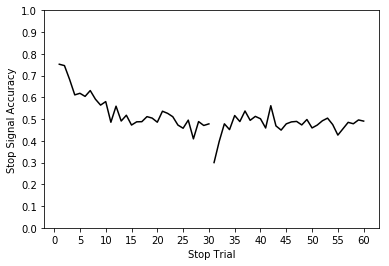

In [69]:
plt.plot(acc_df['StopTrial'][:30], acc_df['Accuracy'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['Accuracy'][30:], color='black')

plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Accuracy')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
#plt.axvline(x=30.5, color = 'grey', alpha = 1.0, lw=1.0, ls='--')
plt.yticks(np.arange(0,1.1, .1))
plt.xticks(np.arange(0,61,5))
plt.show()


#### Issue 8: Low stop probability 

speaks for itself?